In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью make_moons, make_circles и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров:

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification

datasets = [
            make_circles(noise=0.2, factor=0.5, random_state=42),
            make_moons(noise=0.2, random_state=42),
            make_classification(
                                n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, 
                                random_state=3, n_redundant=0., )
            ]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

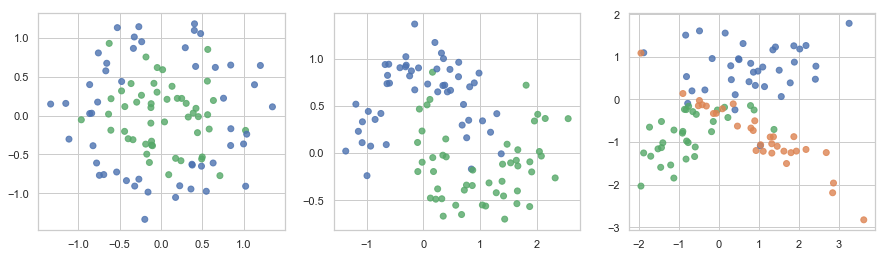

In [4]:
plt.figure(figsize=(15, 4
                   ))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

Для каждого датасета обучим решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Посчитаем accuracy на обучающей и тестовой выборках. Построим разделящие поверхности (через plot_surface): 

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
def plot_surface(clf, X, y, ax):
    plot_step = 0.01
    
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [7]:
def decision_tree(X_train, y_train, X_test, y_test, **kwargs):
    clf = DecisionTreeClassifier(**kwargs).fit(X_train, y_train)
    
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].set_title('Train accuracy = {}'.format(
                                                  accuracy_score(y_train, clf.predict(X_train))
                                                    ))
    axs[1].set_title('Test accuracy = {}'.format(
                                                 accuracy_score(y_test, clf.predict(X_test))
                                                    ))
    plot_surface(clf, X_train, y_train, axs[0])
    plot_surface(clf, X_test, y_test, axs[1])
    plt.show()

In [8]:
train = []
test = []

for X, y in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    train.append((X_train, y_train))
    test.append((X_test, y_test))

Dataset #1


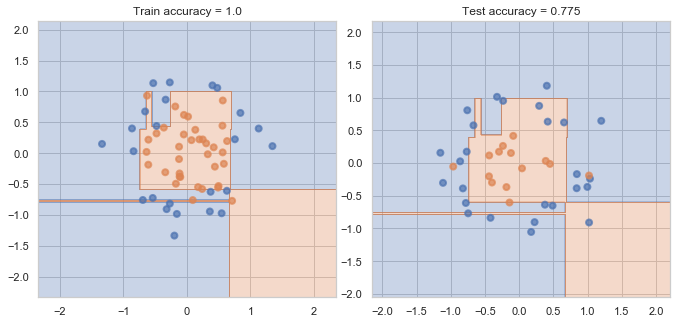

Dataset #2


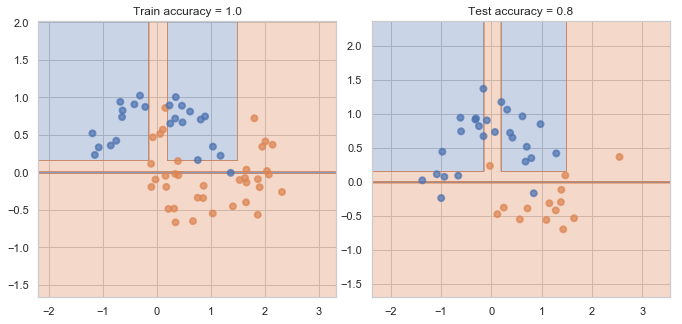

Dataset #3


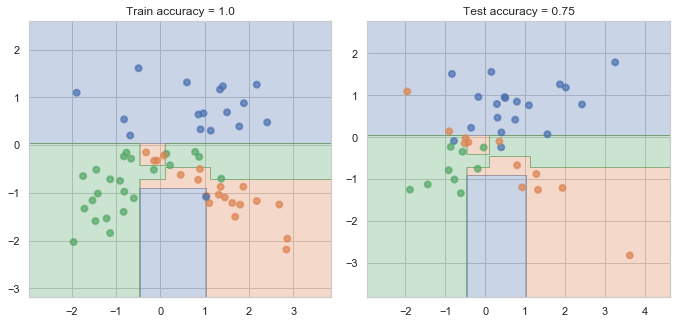

In [9]:
for i in range(len(train)):
    X_train, y_train = train[i]
    X_test, y_test = test[i]
    print('Dataset #{}'.format(i+1))
    
    decision_tree(X_train, y_train, X_test, y_test, random_state=119)

Деревья по умолчанию идеально переобучились: одним из знаков этого являются маленькие полосы, которые отделяют один-единственный объект, а также значение accuracy на train'е.

Попробуем перебрать несколько параметров для регуляризации (max_depth, min_samples_leaf, criteria). Для каждого набора гиперпараметров построим разделяющую поверхность:

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [11]:
X_train, y_train = train[0]
X_test, y_test = test[0]

In [12]:
dtc = DecisionTreeClassifier(random_state=119).fit(X_train, y_train)

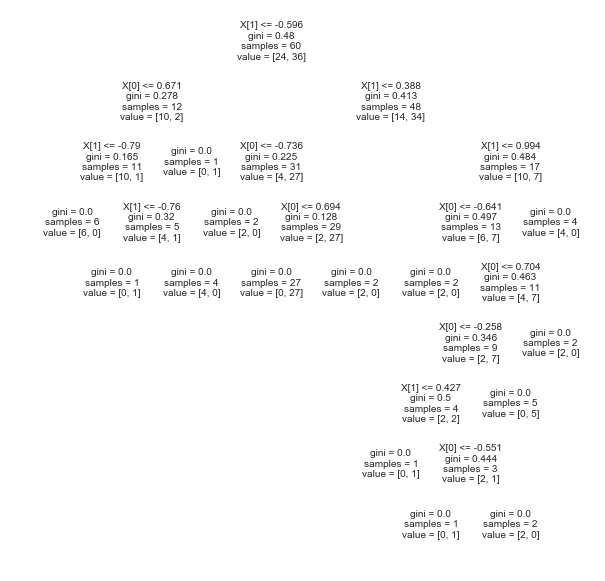

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(dtc, fontsize=10)
plt.show()

In [14]:
param_grid = { 
    'criterion': ["gini", "entropy", "accuracy"],
    'max_depth': [1, 2, 4, 5, 8, 10, 12, 15, 20, 22],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [15]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=119),
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [1, 2, 4, 5, 8, 10, 12, 15, 20, 22],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

In [16]:
CV_dtc.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}

In [17]:
CV_dtc.best_score_

0.8

In [18]:
param_grid = { 
    'criterion': ["gini", "entropy", "accuracy"],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [19]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=119),
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

In [20]:
CV_dtc.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}

In [21]:
CV_dtc.best_score_

0.8

In [22]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, random_state=119). \
                            fit(X_train, y_train)

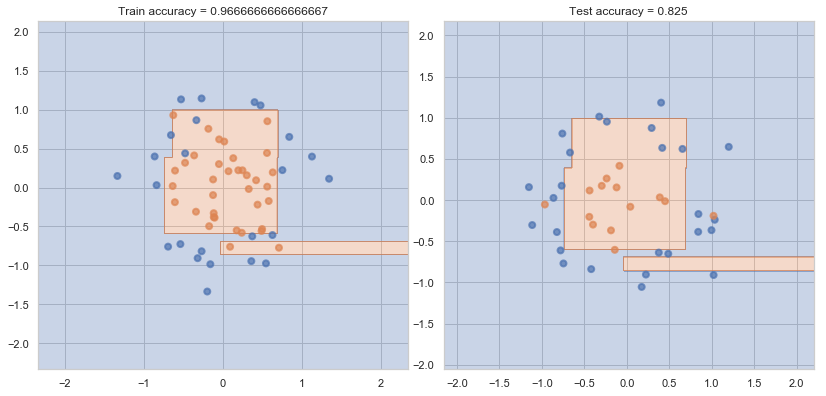

In [23]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].set_title('Train accuracy = {}'.format(accuracy_score(
                                                            y_train, dtc.predict(X_train))
                                                                ))
axs[1].set_title('Test accuracy = {}'.format(accuracy_score(
                                                            y_test, dtc.predict(X_test))
                                                                ))
plot_surface(dtc, X_train, y_train, axs[0])
plot_surface(dtc, X_test, y_test, axs[1])
plt.show()

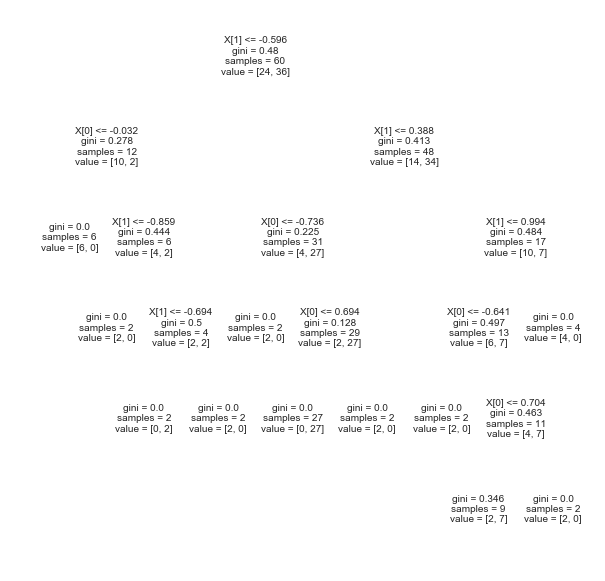

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(dtc, fontsize=10)
plt.show()

In [25]:
param_grid = { 
    'criterion': ["gini", "accuracy"],
    'max_depth': [13, 14, 15, 16, 17],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10, 15]
}

In [26]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                                              random_state=119),
             param_grid={'criterion': ['gini', 'accuracy'],
                         'max_depth': [13, 14, 15, 16, 17],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10, 15]})

In [27]:
CV_dtc.best_params_

{'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 2}

In [28]:
CV_dtc.best_score_

0.7666666666666667

In [29]:
dtc2 = DecisionTreeClassifier(criterion='gini', max_depth=13, min_samples_leaf=2, random_state=119). \
                            fit(X_train, y_train)

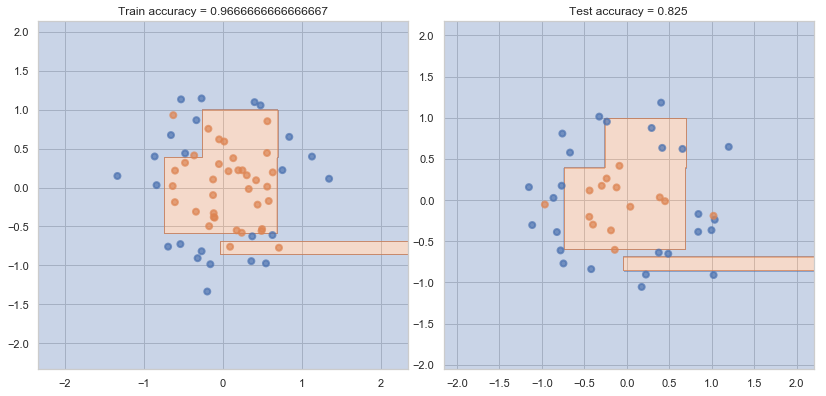

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].set_title('Train accuracy = {}'.format(accuracy_score(
                                                            y_train, dtc2.predict(X_train))
                                                                ))
axs[1].set_title('Test accuracy = {}'.format(accuracy_score(
                                                            y_test, dtc2.predict(X_test))
                                                                ))
plot_surface(dtc2, X_train, y_train, axs[0])
plot_surface(dtc2, X_test, y_test, axs[1])
plt.show()

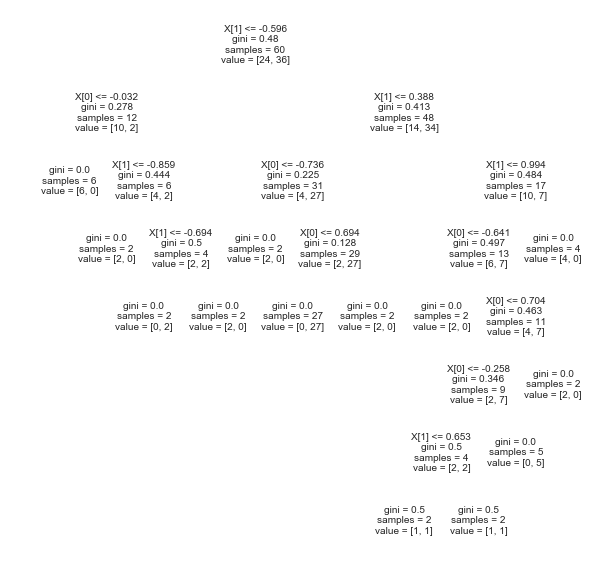

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(dtc2, fontsize=10)
plt.show()

Видим, что деревья получились практически одинаковые, несмотря на разную доспустимую глубину (5 и 13).

Попробуем перебирать параметры несколько иначе:

Tree depth = 4


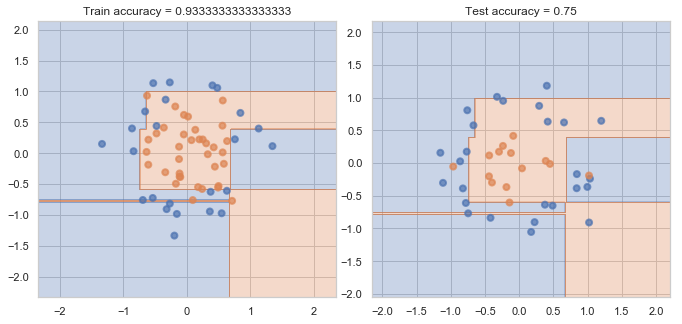

Tree depth = 5


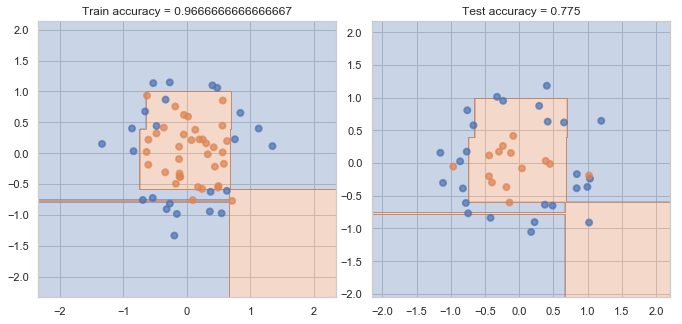

Tree depth = 6


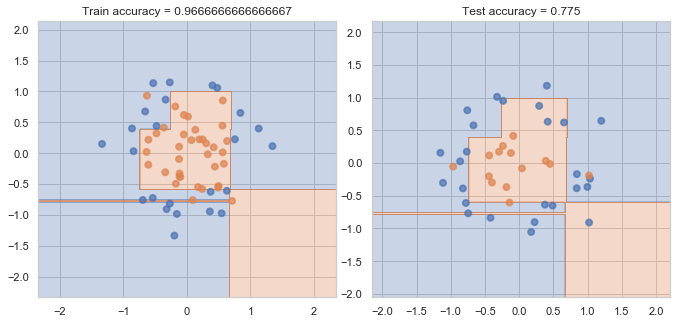

Tree depth = 12


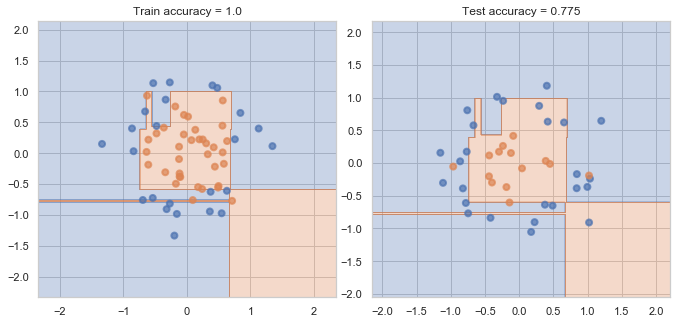

Tree depth = 13


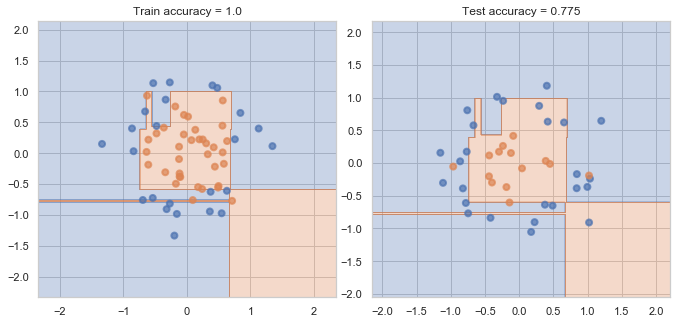

Tree depth = 14


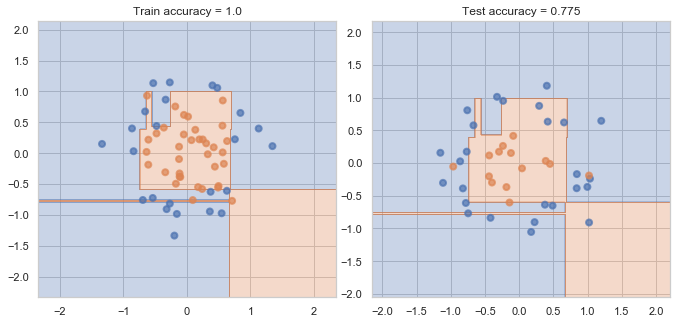

In [32]:
a = [4, 5, 6, 12, 13, 14]
for d in a:
    print(f"Tree depth = {d}")
    
    decision_tree(X_train, y_train, X_test, y_test, max_depth=d, random_state=119)

Min leafs = 1


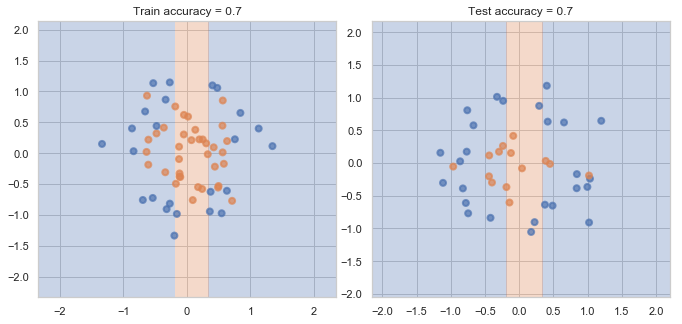

Min leafs = 2


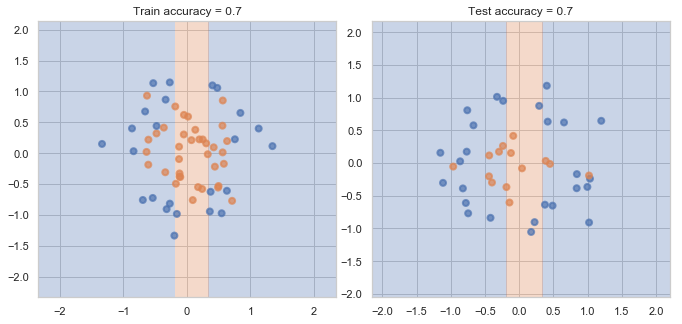

Min leafs = 3


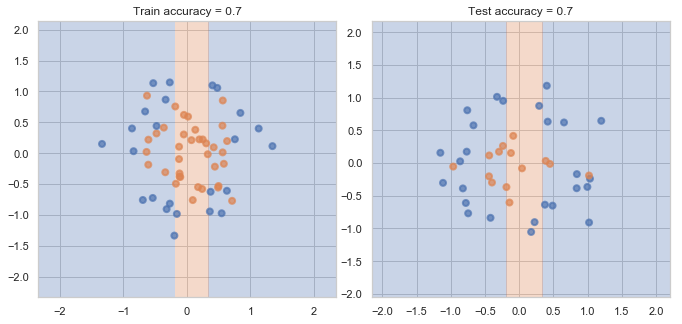

Min leafs = 4


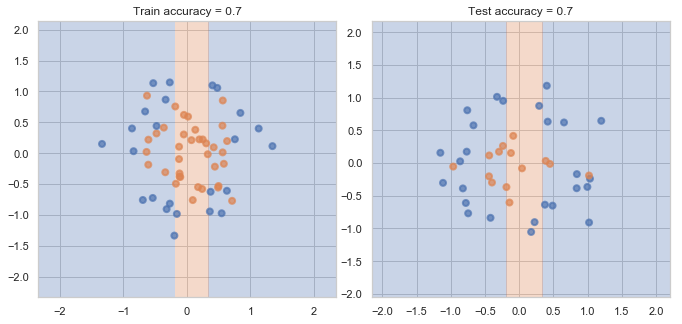

Min leafs = 5


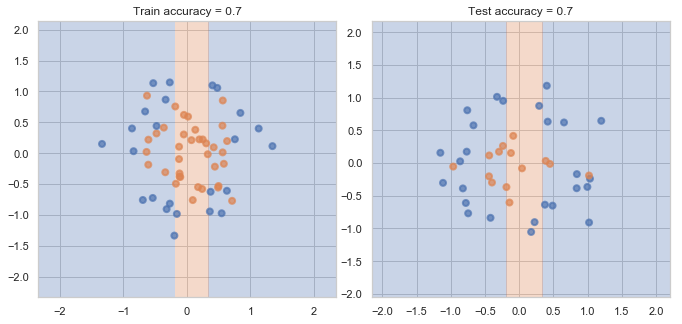

In [33]:
a = [1, 2, 3, 4, 5]
for l in a:
    print(f"Min leafs = {l}")
    
    decision_tree(X_train, y_train, X_test, y_test, max_depth=5, min_samples_leaf=d, random_state=119)

При ```max_depth=5``` и ```min_samples_leaf=4``` наблюдаем наилучшее значение accuracy и наименьшее переобучение.

-----

Перейдем ко второму датасету:

In [34]:
X_train, y_train = train[1]
X_test, y_test = test[1]

In [35]:
dtc = DecisionTreeClassifier(random_state=119).fit(X_train, y_train)

In [36]:
param_grid = { 
    'criterion': ["gini", "entropy", "accuracy"],
    'max_depth': [1, 2, 4, 5, 8, 10, 12, 15, 20, 22],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]
}

In [37]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=119),
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [1, 2, 4, 5, 8, 10, 12, 15, 20, 22],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]})

In [38]:
CV_dtc.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}

In [39]:
param_grid = { 
    'criterion': ["gini", "entropy", "accuracy"],
    'max_depth': [3, 4, 5, 10, 12, 14, 16],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]
}

In [40]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=119),
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [3, 4, 5, 10, 12, 14, 16],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]})

In [41]:
CV_dtc.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}

In [42]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=1, random_state=119). \
                            fit(X_train, y_train)

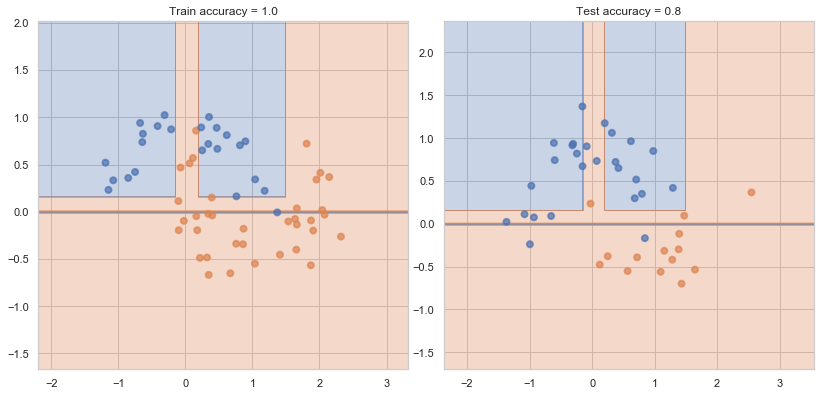

In [43]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].set_title('Train accuracy = {}'.format(accuracy_score(
                                                            y_train, dtc.predict(X_train))
                                                                ))
axs[1].set_title('Test accuracy = {}'.format(accuracy_score(
                                                            y_test, dtc.predict(X_test))
                                                                ))
plot_surface(dtc, X_train, y_train, axs[0])
plot_surface(dtc, X_test, y_test, axs[1])
plt.show()

Max depth = 3, min leafs = 1


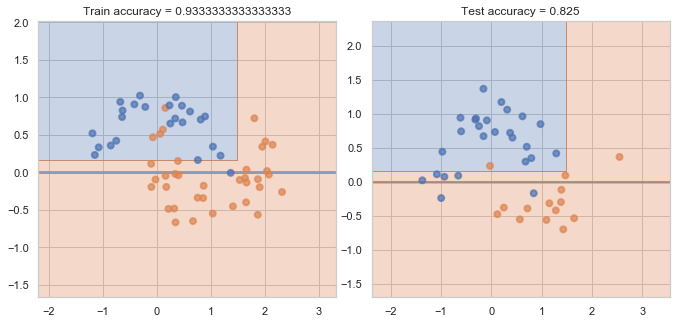

Max depth = 3, min leafs = 2


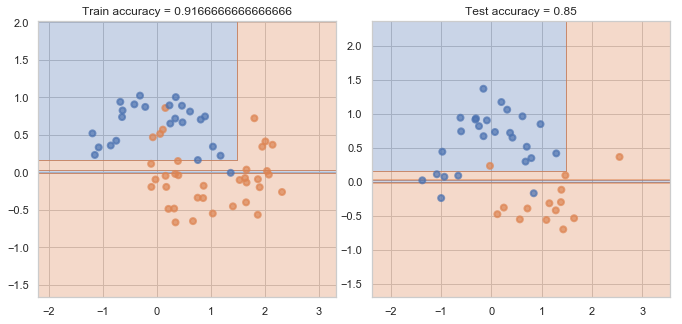

Max depth = 3, min leafs = 7


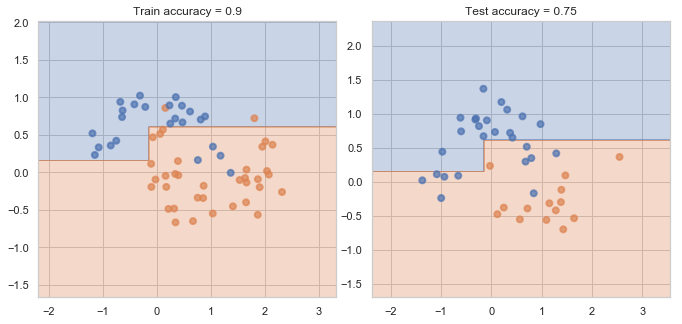

Max depth = 4, min leafs = 1


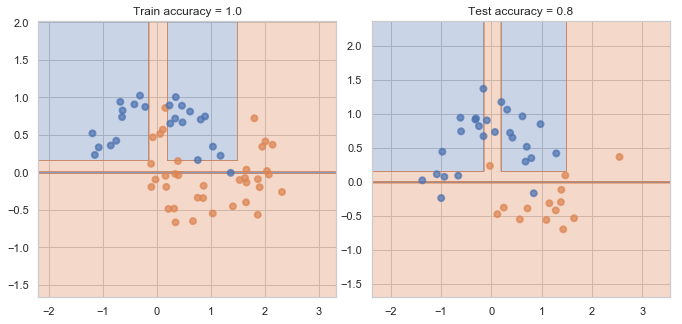

Max depth = 4, min leafs = 2


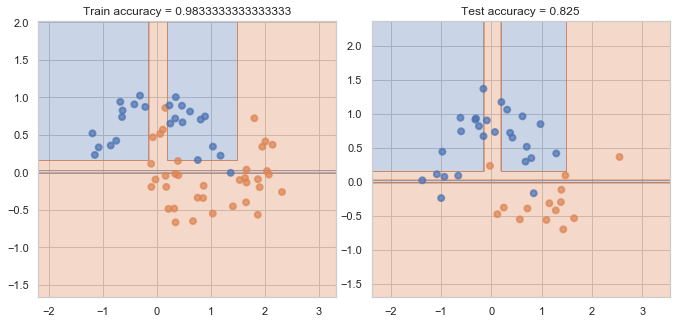

Max depth = 4, min leafs = 7


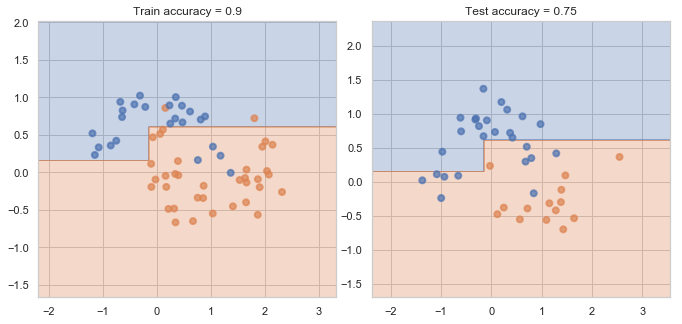

Max depth = 5, min leafs = 1


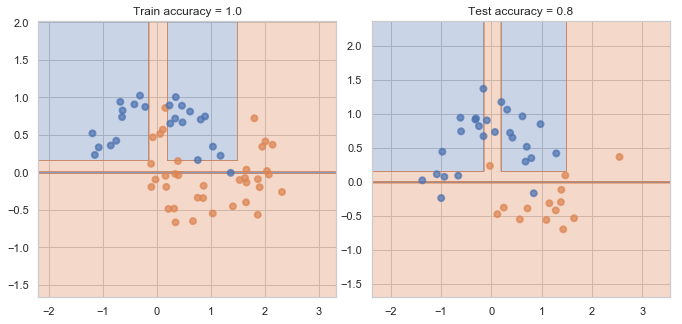

Max depth = 5, min leafs = 2


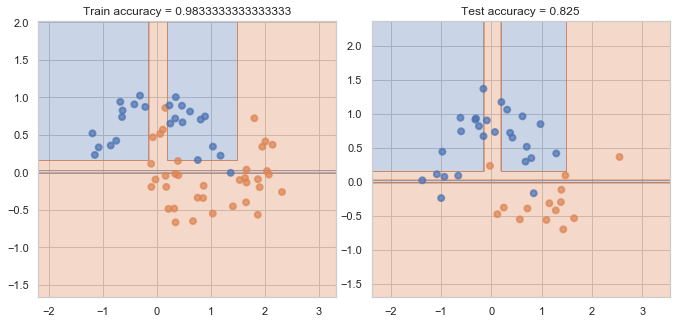

Max depth = 5, min leafs = 7


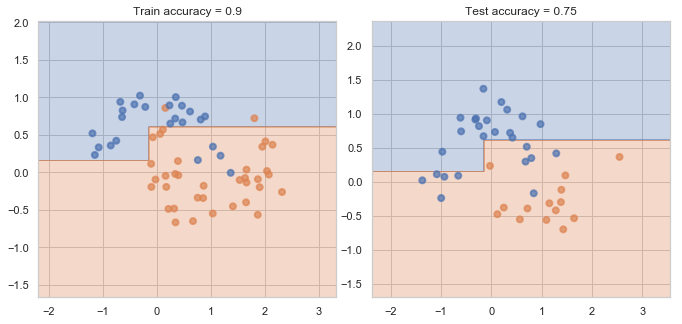

In [44]:
a = [3, 4, 5]
b = [1, 2, 7]

for depth in a:
    for leafs in b:
        print(f"Max depth = {depth}, min leafs = {leafs}")
        
        decision_tree(X_train, y_train, X_test, y_test, 
                          max_depth=depth, min_samples_leaf=leafs, random_state=119)

При ```max_depth=3``` и ```min_samples_leaf=1``` наблюдаем наилучшее значение accuracy и наименьшее переобучение.

---

Перейдем к третьему датасету:

In [45]:
X_train, y_train = train[2]
X_test, y_test = test[2]

In [46]:
dtc = DecisionTreeClassifier(random_state=119).fit(X_train, y_train)

In [47]:
param_grid = { 
    'criterion': ["gini", "entropy", "accuracy"],
    'max_depth': [1, 2, 4, 5, 8, 10, 12, 15, 20, 22],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]
}

In [48]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=119),
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [1, 2, 4, 5, 8, 10, 12, 15, 20, 22],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]})

In [49]:
CV_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}

In [50]:
param_grid = { 
    'criterion': ["gini", "entropy", "accuracy"],
    'max_depth': [1, 2, 3, 4, 5, 13, 14, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]
}

In [51]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=119),
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [1, 2, 3, 4, 5, 13, 14, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 7, 8]})

In [52]:
CV_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}

In [53]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=1, random_state=119). \
                            fit(X_train, y_train)

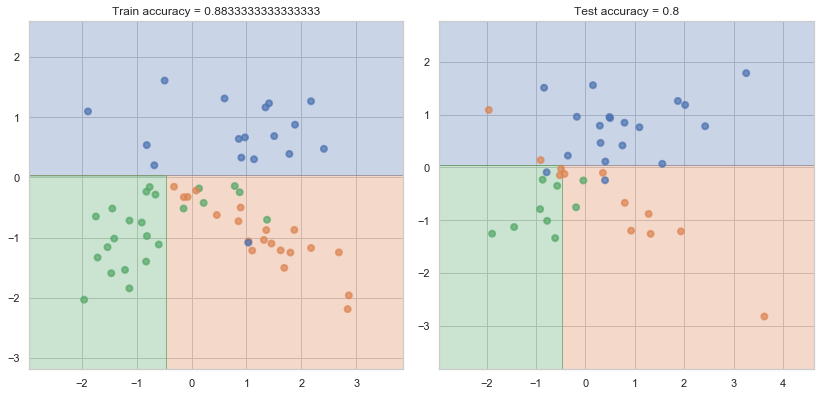

In [54]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].set_title('Train accuracy = {}'.format(accuracy_score(
                                                            y_train, dtc.predict(X_train))
                                                                ))
axs[1].set_title('Test accuracy = {}'.format(accuracy_score(
                                                            y_test, dtc.predict(X_test))
                                                                ))
plot_surface(dtc, X_train, y_train, axs[0])
plot_surface(dtc, X_test, y_test, axs[1])
plt.show()

Max depth = 1, min leafs = 1, criterion = entropy


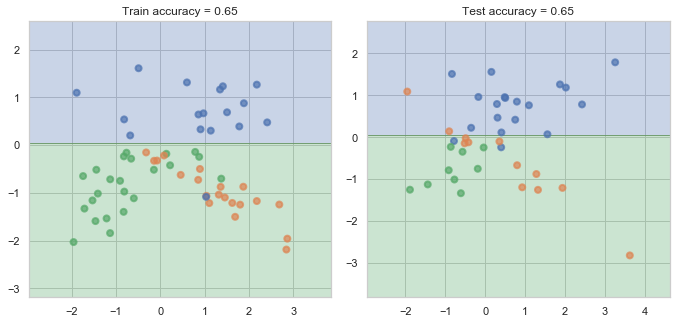

Max depth = 1, min leafs = 2, criterion = entropy


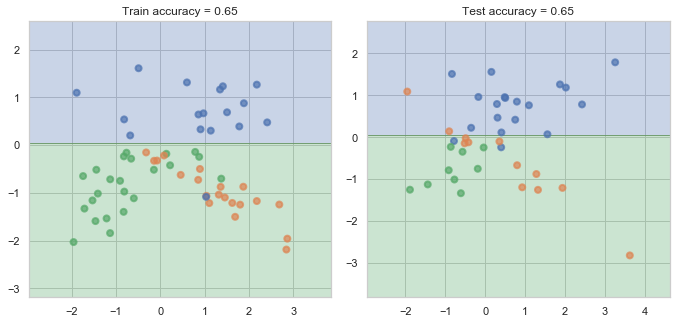

Max depth = 1, min leafs = 3, criterion = entropy


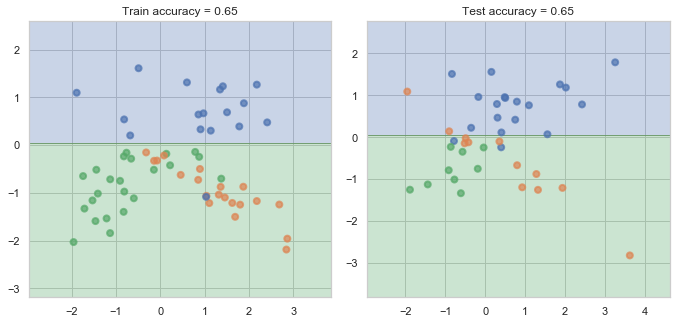

Max depth = 1, min leafs = 7, criterion = entropy


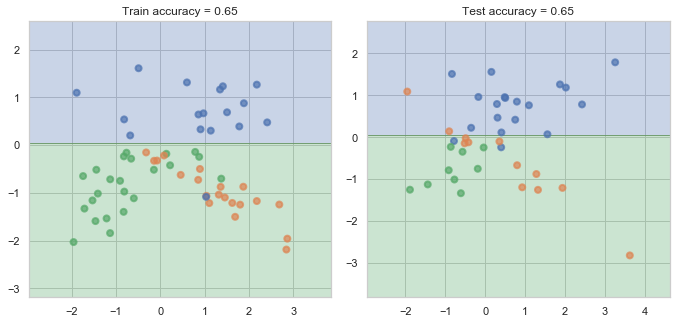

Max depth = 2, min leafs = 1, criterion = entropy


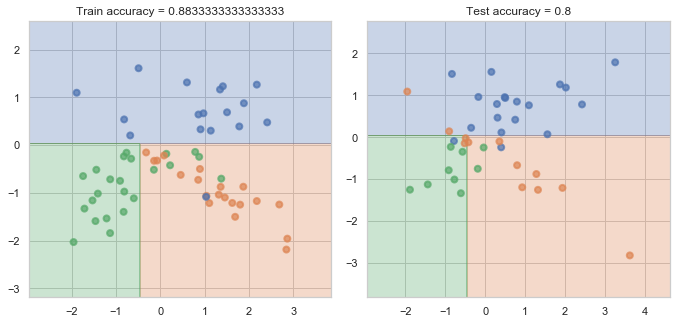

Max depth = 2, min leafs = 2, criterion = entropy


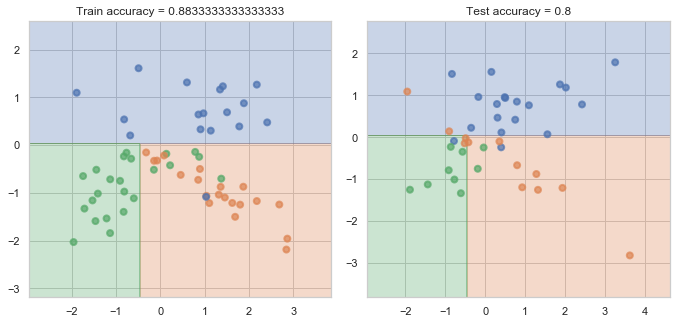

Max depth = 2, min leafs = 3, criterion = entropy


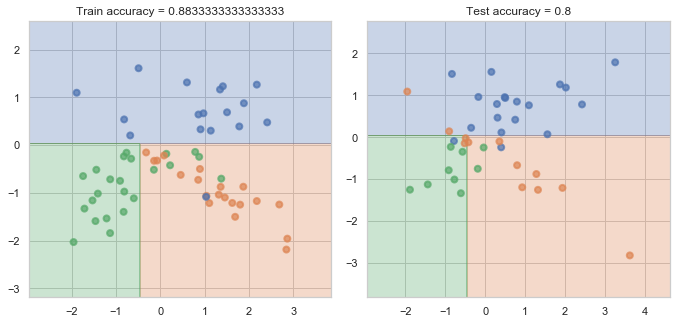

Max depth = 2, min leafs = 7, criterion = entropy


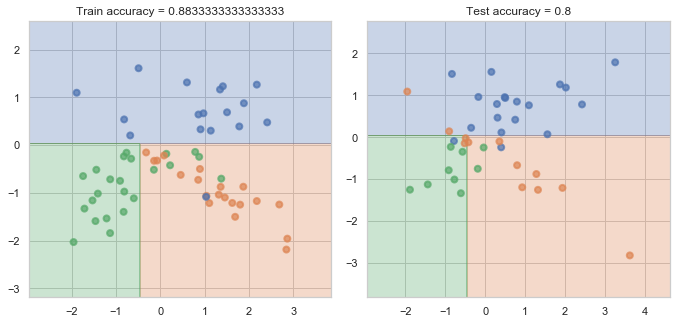

Max depth = 3, min leafs = 1, criterion = entropy


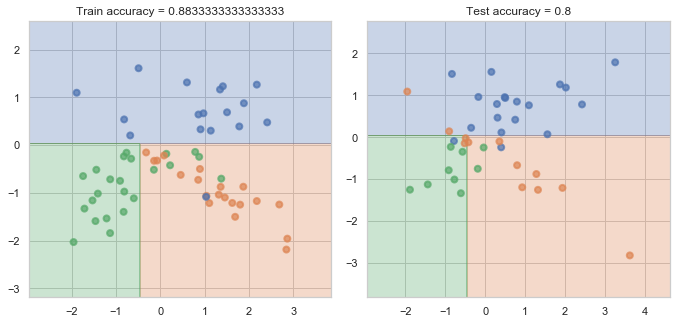

Max depth = 3, min leafs = 2, criterion = entropy


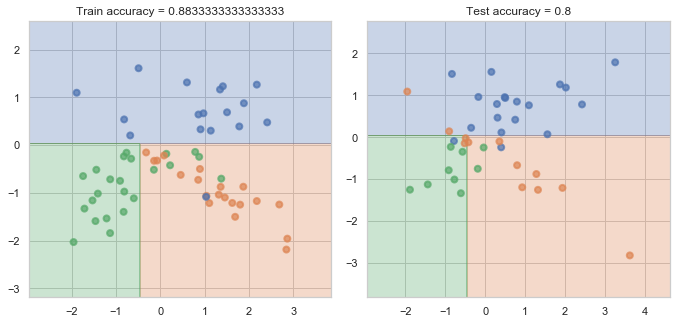

Max depth = 3, min leafs = 3, criterion = entropy


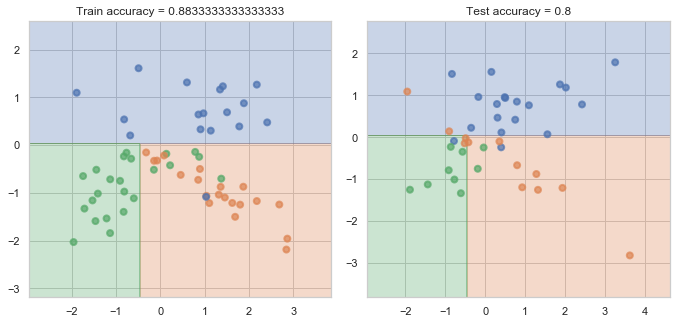

Max depth = 3, min leafs = 7, criterion = entropy


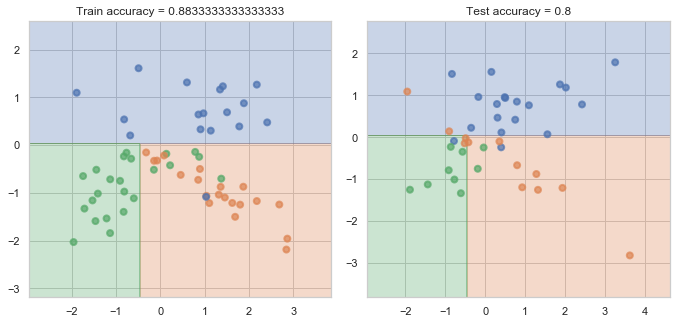

Max depth = 4, min leafs = 1, criterion = entropy


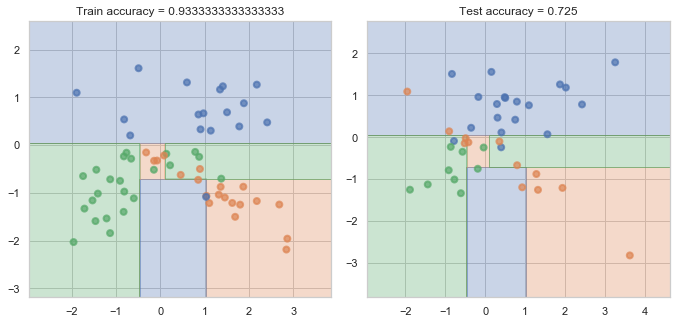

Max depth = 4, min leafs = 2, criterion = entropy


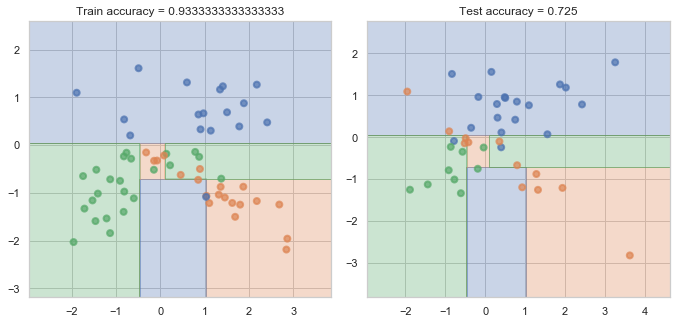

Max depth = 4, min leafs = 3, criterion = entropy


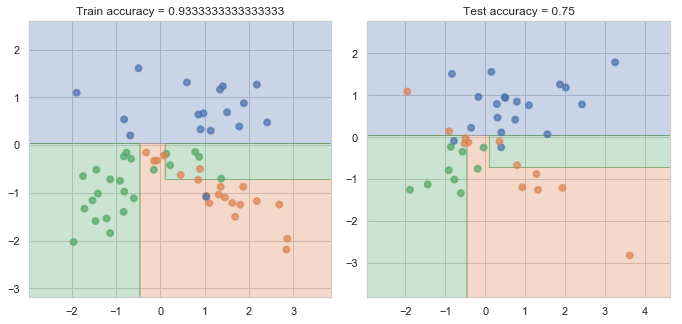

Max depth = 4, min leafs = 7, criterion = entropy


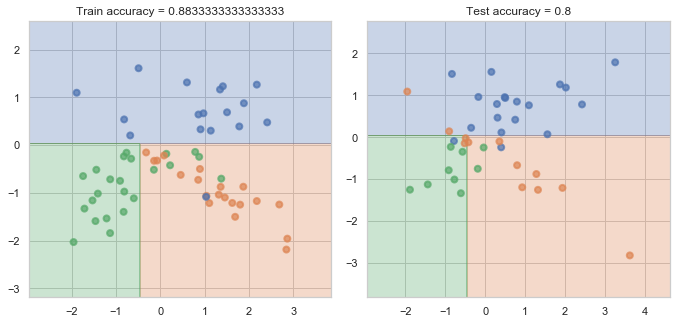

In [55]:
a = [1, 2, 3, 4]
b = [1, 2, 3, 7]
criteria = "entropy"

for depth in a:
    for leafs in b:
        print(f"Max depth = {depth}, min leafs = {leafs}, criterion = {criteria}")
        
        decision_tree(X_train, y_train, X_test, y_test, 
                            criterion = criteria, max_depth=depth, min_samples_leaf=leafs, random_state=119)

При ```max_depth=3``` (4) и ```min_samples_leaf=1``` (7) наблюдаем наилучшее значение accuracy и наименьшее переобучение.

---
---
---

### Решающие деревья своими руками

В этой части мы реализуем свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Реализуем функцию find_best_split в модуле treeClass.py

Под критерием Джини подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

In [56]:
import numpy as np
from treeClass import find_best_split

In [57]:
feature_vector = [0.5, 0.74, 0.5, 1]

find_best_split(np.array(feature_vector), np.array([0, 1, 0, 1]))

(array([0.62, 0.87]), array([-0.        , -0.33333333]), 0.62, -0.0)

[Таблица](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постромс на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируем scatter-графики "значение признака — класс" для всех пяти признаков:

In [58]:
data = pd.read_csv("students.csv")
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [59]:
np.sum(data.isnull())

STG     0
SCG     0
STR     0
LPR     0
PEG     0
 UNS    0
dtype: int64

In [60]:
y = data[' UNS']
X = data.drop([' UNS'], axis=1)

In [61]:
X.sample(1)

,STG,SCG,STR,LPR,PEG
245,0.91,0.58,0.26,0.89,0.88


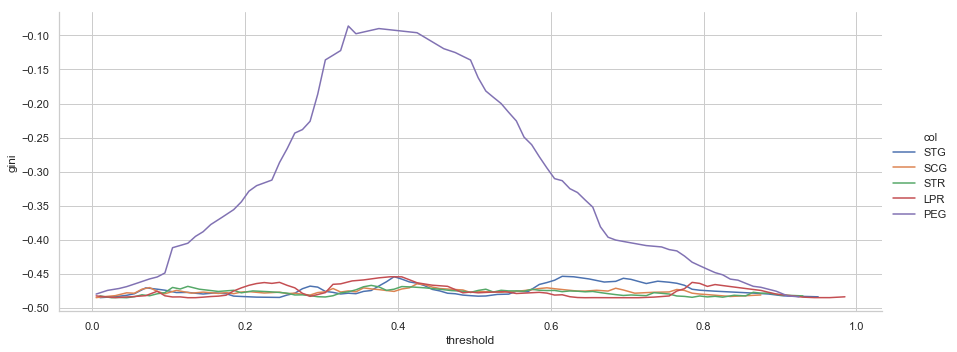

In [62]:
columns = X.columns
students_data = pd.DataFrame(columns=['threshold', 'gini', 'col'])

for col in columns:
    thresholds, ginis, _, _ = find_best_split(np.array(X[col]), np.array(y))
    
    cur_data = pd.DataFrame(columns=['threshold', 'gini', 'col'])
    cur_data['threshold'] = thresholds
    cur_data['gini'] = ginis
    cur_data['col'] = col
    
    students_data = pd.concat([students_data, cur_data],  ignore_index=True)

g = sns.relplot(
                x='threshold', y='gini', 
                hue='col', 
                kind='line',
                height=5, aspect=2.5,
                data=students_data
            )

Попробуем изобразить более понятно:

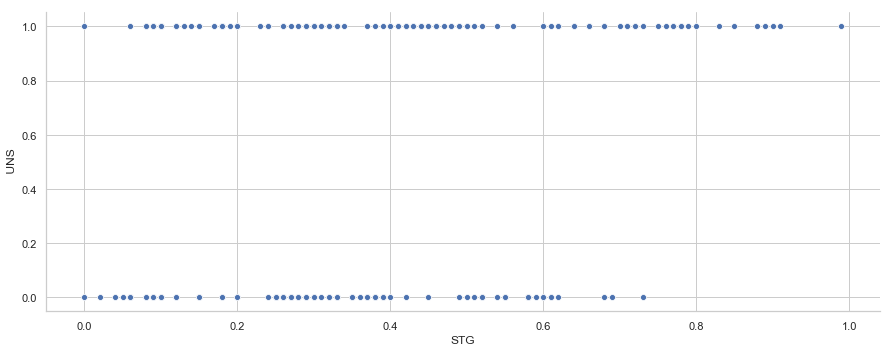

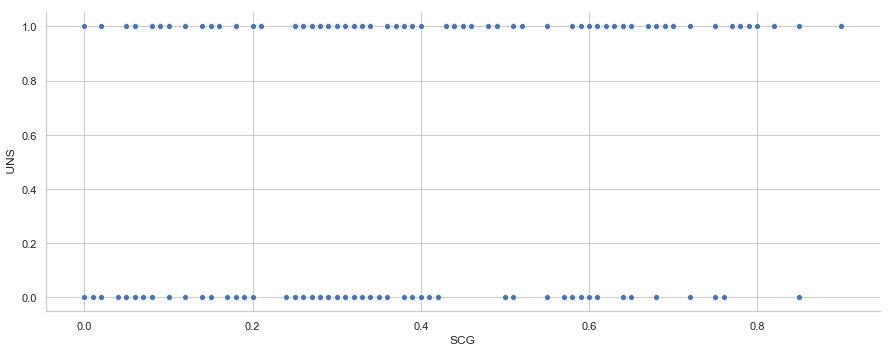

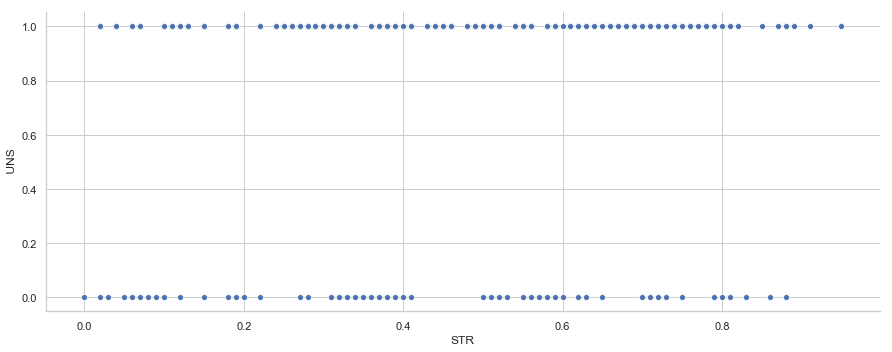

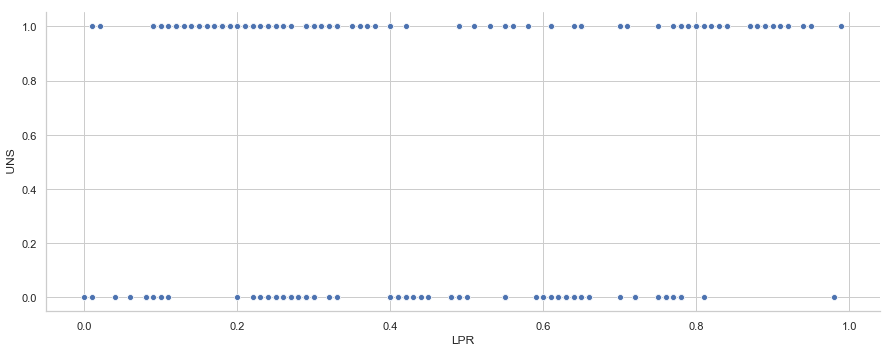

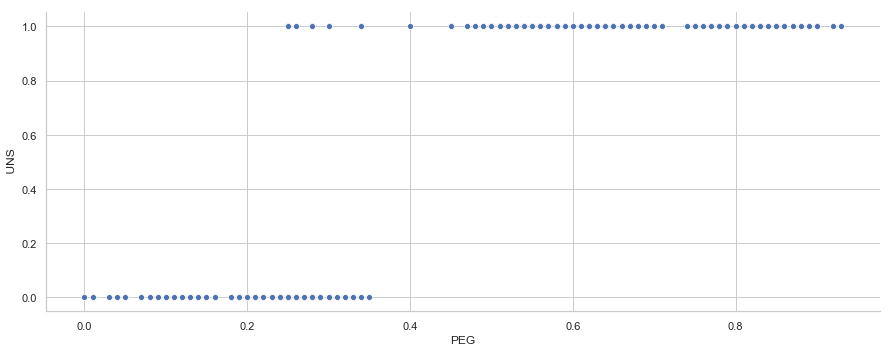

In [63]:
for col in columns:
    g = sns.relplot(
                    x=col, y=' UNS',
                    kind='scatter',
                    height=5, aspect=2.5,
                    data=data
                )

Доправим реализацию метода fit_node. Напишем функцию predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму. Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование.

Хорошие признаки - это те, где значение критерия Джини достаточно большое и имеет четкий экстремум, в то время как плохие признаки имеют примерно одинаково низкое значение критерия постоянно.

По критерию Джини, нужно разделить по признаку PEG, и это почти идеально согласуется с визуальной оценкой scatter графика для этого признака - мы действительно можем практически точно провести разбиение в окрестности точки 0.4.

In [64]:
from treeClass import find_best_split, DecisionTree

In [65]:
X_train = np.array([
                    [3, 1, 1], [2, 1, 2], [1, 3, 3], [2, 3, 1], [2, 2, 2], [1, 2, 3]
                ])
y_train = np.array( [0, 1, 0, 1, 1, 0] )

In [66]:
X_test = np.array([
                    [2, 1, 7], [0, 8, 4], [1, 1, 1]
                ])
y_test = np.array( [1, 0, 0] )

In [67]:
clf = DecisionTree(['real']*3, min_samples_leaf=2).fit(X_train, y_train)
clf.predict(X_test)

array([0, 0, 0])

In [68]:
clf._tree

{'type': 'nonterminal',
 'feature_split': 0,
 'threshold': 1.5,
 'left_child': {'type': 'terminal', 'class': 0},
 'right_child': {'type': 'nonterminal',
  'feature_split': 1,
  'threshold': 1.5,
  'left_child': {'type': 'terminal', 'class': 0},
  'right_child': {'type': 'terminal', 'class': 1}}}

Протестируем свое решающее дерево на датасете mushrooms (таблица [agaricus-lepiota.data](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)).
<br>Первый столбец — это целевая переменная (e — edible, p — poisonous).

Обучим решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделаем предсказания для оставшейся половины. Вычислите accuracy:

In [69]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [70]:
df.shape

(8123, 23)

Вместо LabelEncoder используем OrdinalEncoder - суть та же, но при этом умеет работать с column transformer:

In [71]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [72]:
ct = ColumnTransformer([
                        ("oe", OrdinalEncoder(), list(range(23)))
                    ])

df = ct.fit_transform(df)

In [73]:
y = df[:, 0]
X = df[:, 1:]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [75]:
clf = DecisionTree(["categorical"] * 23).fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

1.0

In [76]:
clf._tree

{'type': 'nonterminal',
 'feature_split': 4,
 'categories_split': [5.0, 0.0, 3.0],
 'left_child': {'type': 'nonterminal',
  'feature_split': 19,
  'categories_split': [7.0, 2.0, 3.0, 4.0, 1.0, 0.0, 8.0, 6.0],
  'left_child': {'type': 'nonterminal',
   'feature_split': 14,
   'categories_split': [7.0, 6.0, 5.0, 2.0, 3.0, 4.0],
   'left_child': {'type': 'nonterminal',
    'feature_split': 1,
    'categories_split': [3.0, 0.0, 2.0],
    'left_child': {'type': 'nonterminal',
     'feature_split': 0,
     'categories_split': [5.0, 3.0, 2.0, 0.0, 4.0],
     'left_child': {'type': 'nonterminal',
      'feature_split': 14,
      'categories_split': [7.0, 6.0, 5.0, 2.0, 3.0],
      'left_child': {'type': 'nonterminal',
       'feature_split': 21,
       'categories_split': [6.0, 0.0, 3.0, 1.0, 4.0, 5.0],
       'left_child': {'type': 'terminal', 'class': 0.0},
       'right_child': {'type': 'nonterminal',
        'feature_split': 1,
        'categories_split': [2.0],
        'left_child': {'typ

---
---
---

Реализуем в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Построим графики зависимости качества предсказания в зависимости от этих параметров для набора данных [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame):

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [78]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
df.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


In [79]:
ct = ColumnTransformer([
                        ("oe", OrdinalEncoder(), list(range(10)))
                    ])

df = ct.fit_transform(df)

In [80]:
y = df[:, -1]
X = df[:, :-1]

In [81]:
params_test = pd.DataFrame( columns=["value", "accuracy", "type"] )

for d in range(1, 20):
    class DecisionTreeCategorical(DecisionTree):
        def __init__(self):
            DecisionTree.__init__(self, ["categorical"]*200, max_depth=d)
            
    acc = cross_val_score(
                            DecisionTreeCategorical(), 
                            X, y, 
                            cv=10, 
                            scoring=make_scorer(accuracy_score),
                            fit_params={}
                        ).mean()
    params_test = params_test.append(
                                    {"value": d, "accuracy": acc, "type": "max depth"}, 
                                    ignore_index=True
                                )
    
for d in range(1, 20):
    class DecisionTreeCategorical(DecisionTree):
        def __init__(self):
            DecisionTree.__init__(self, ["categorical"]*200, min_samples_leaf=d)
            
    acc = cross_val_score(
                            DecisionTreeCategorical(), 
                            X, y, 
                            cv=10, 
                            scoring=make_scorer(accuracy_score),
                            fit_params={}
                        ).mean()
    params_test = params_test.append(
                                    {"value": d, "accuracy": acc, "type": "min samples leaf"}, 
                                    ignore_index=True
                                )
    
for d in range(1, 20):
    class DecisionTreeCategorical(DecisionTree):
        def __init__(self):
            DecisionTree.__init__(self, ["categorical"]*200, min_samples_split=d)
            
    acc = cross_val_score(
                            DecisionTreeCategorical(), 
                            X, y, 
                            cv=10, 
                            scoring=make_scorer(accuracy_score),
                            fit_params={}
                        ).mean()
    params_test = params_test.append(
                                    {"value": d, "accuracy": acc, "type": "max samples split"}, 
                                    ignore_index=True
                                )

In [82]:
params_test

,value,accuracy,type
0,1,0.572346,max depth
1,2,0.550548,max depth
2,3,0.416020,max depth
3,4,0.456809,max depth
4,5,0.487434,max depth
5,6,0.545066,max depth
6,7,0.550318,max depth
7,8,0.548213,max depth
8,9,0.549265,max depth
9,10,0.549265,max depth


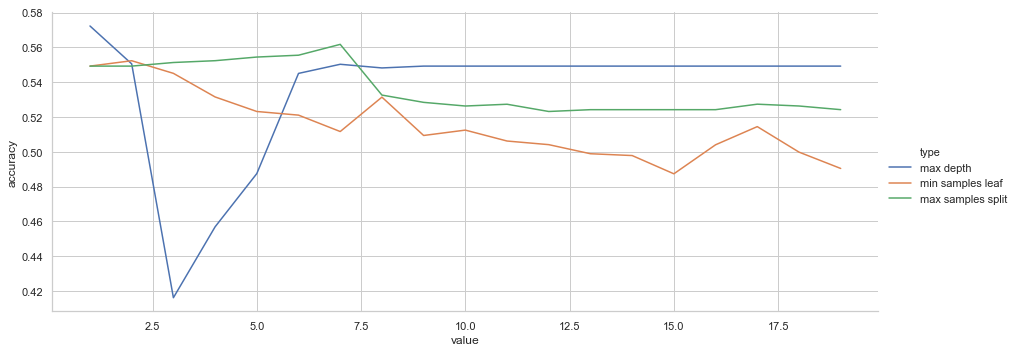

In [83]:
g = sns.relplot(
                x='value', y='accuracy',
                hue='type',
                kind='line',
                height=5, aspect=2.5,
                data=params_test
            )

Наиболее удачным оказалось следующее дерево (пень):
<br> ```max_depth=1```, ```min_samples_leaf=2```, ```max_samples_split=6```.

---

Загрузим следующие наборы данных: 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

In [84]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
tic_tac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')

Закодируем категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оценим accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

In [85]:
mushrooms.head(2)  

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m


In [86]:
tic_tac_toe.head(2)

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive


In [87]:
cars.head(2)

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc


In [88]:
nursery.head(2)

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom


In [89]:
class DecisionTreeReal(DecisionTree):
    def __init__(self):
        DecisionTree.__init__(self, ["real"]*200)

In [90]:
class DecisionTreeCategorical(DecisionTree):
    def __init__(self):
        DecisionTree.__init__(self, ["categorical"]*200)

In [91]:
def get_oe(ncols):
    ct = ColumnTransformer([
                            ("oe", OrdinalEncoder(), list(range(ncols)))
                        ])
    
    return ct

def get_ohe(ncols):
    ct = ColumnTransformer([
                            ("ohe", OneHotEncoder(sparse=False), list(range(ncols)))
                        ])
    
    return ct

# input: pd.Dataframe
def le_init(data):
    ct = get_oe( len(data.columns) )
    
    return ct.fit_transform(data)

def calc_ohe(data):
    ct = get_ohe( data.shape[1] )
    
    return ct.fit_transform(data)

In [92]:
datasets = [(
                le_init(mushrooms.drop(['p'], axis=1)), 
                np.array(mushrooms['p'] == 'e', dtype=int)
        ),
            (
                le_init(tic_tac_toe.drop(['positive'], axis=1)), 
                np.array(tic_tac_toe['positive'] == 'positive', dtype=int)
        ),
            (
                le_init(cars.drop(['unacc'], axis=1)), 
                np.array((cars['unacc'] == 'good') | (cars['unacc'] == 'vgood'), dtype=int)
        ),
            (
                le_init(nursery.drop(['recommend'], axis=1)), 
                np.array(
                        (nursery['recommend'] == 'very_recom') | \
                             (nursery['recommend'] == 'priority') | \
                                 (nursery['recommend'] == 'spec_prior'),
                         dtype=int
                      )
        )]

In [93]:
results = pd.DataFrame(
                        columns=['real', 'categorical', 'ohe', 'sklearn']
                    )

In [94]:
clfs = {
        'real': DecisionTreeReal(),
        'categorical': DecisionTreeCategorical(),
        'ohe': DecisionTreeReal(),
        'sklearn': DecisionTreeClassifier()
    }

In [95]:
for X, y in datasets:
    local_result = {}
    
    for atype in ['real', 'categorical', 'ohe', 'sklearn']:
        clf = clfs[atype]
        if atype == 'ohe':
            X = calc_ohe(X)
            
        acc = cross_val_score(
                                clf, 
                                X, y, 
                                cv=10, 
                                scoring=make_scorer(accuracy_score)
                        ).mean()
        local_result[atype] = acc
        
    results = results.append(local_result, ignore_index=True)

In [96]:
results['data_name'] = ['mushrooms', 'tic_tac_toe', 'cars', 'nursery']

cols = results.columns.tolist()
cols = cols[-1:] + cols[:-1]
results = results[cols]

results

,data_name,real,categorical,ohe,sklearn
0,mushrooms,0.999261,1.000000,0.999631,0.967403
1,tic_tac_toe,0.462697,0.549265,0.553520,0.812160
2,cars,0.942600,0.967519,0.921767,0.834521
3,nursery,0.999846,0.999923,0.999769,0.999923


Заметим, что оригинальное решающее дерево из коробки справляется во всех случаях хуже, чем обучение по категориальным, кроме случая 2-го датасета. Вероятно это связано с тем, что оно не умеет так работать с категориальными признаками, как работаем с ними мы.

По всей видимости, во 2м датасете происходит переобучение самодельных алгоритмов, но sklearn'овский в процессе кросс-валидации через регуляризации всевозможные справляется лучше.